🚀 [FlowScore 6.0 Final] 심사역을 위한 모델 설명서 생성 중...
✅ 모델 로드 완료: FlowScore_6.0_Final_Hybrid.pkl
✅ [1] 중요도 그래프 저장됨: FlowScore_6.0_Importance.png
📊 [2] 우량 vs 부실 기업 패턴 비교 차트 생성 중...
✅ [2] 레이더 차트 저장됨: FlowScore_6.0_Radar_Chart.png

📋 [FlowScore 6.0 심사 가이드라인]
                      한글명       카테고리                        설명  AI중요도순위
Tx_Volatility       자금변동성   보조지표(AI)  월별 자금 소요의 불규칙성 (낮을수록 좋음)        1
CEO_Score         CEO신용점수        신뢰도                대표자 개인 신용도        2
Avg_Tx_Hour        평균결제시간   보조지표(AI)    주로 결제하는 시간대 (오전일수록 좋음)        3
Late_Pay_Ratio     오후결제비율  핵심지표(심사역)            마감 시간 임박 결제 비중        4
Debt_Ratio           부채비율       기초체력               자본 대비 부채 비중        5
OPM_Change          이익률변화       기초체력                 수익성 개선 여부        6
Rev_Per_Emp         인당생산성       기초체력                직원 1인당 매출액        7
Biz_Score          기업신용점수  핵심지표(심사역)             외부 평가기관 등급 점수        8
Avg_Delay_Days     평균지연일수  핵심지표(심사역)             지급 예정일 대비 지연일        9
Current_Ratio        유동비율      

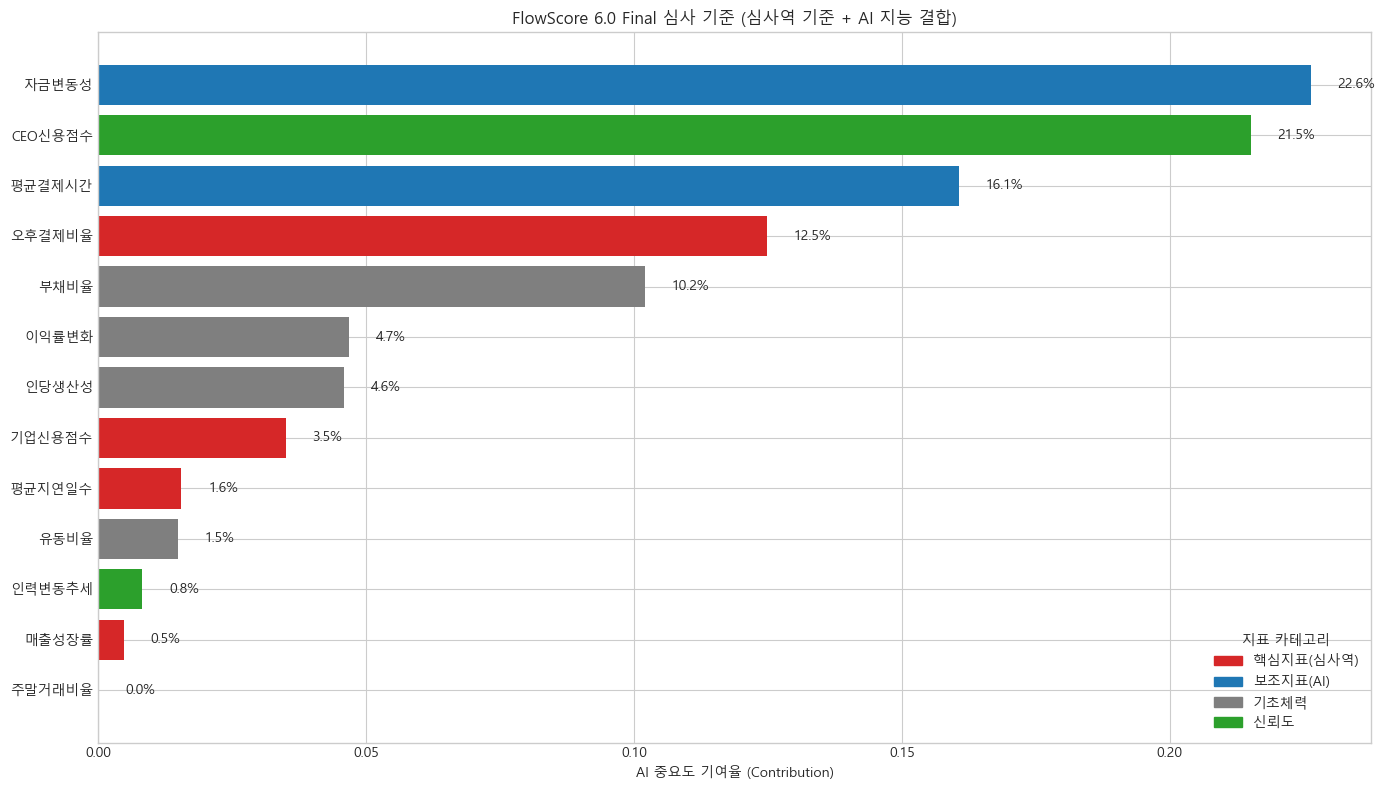

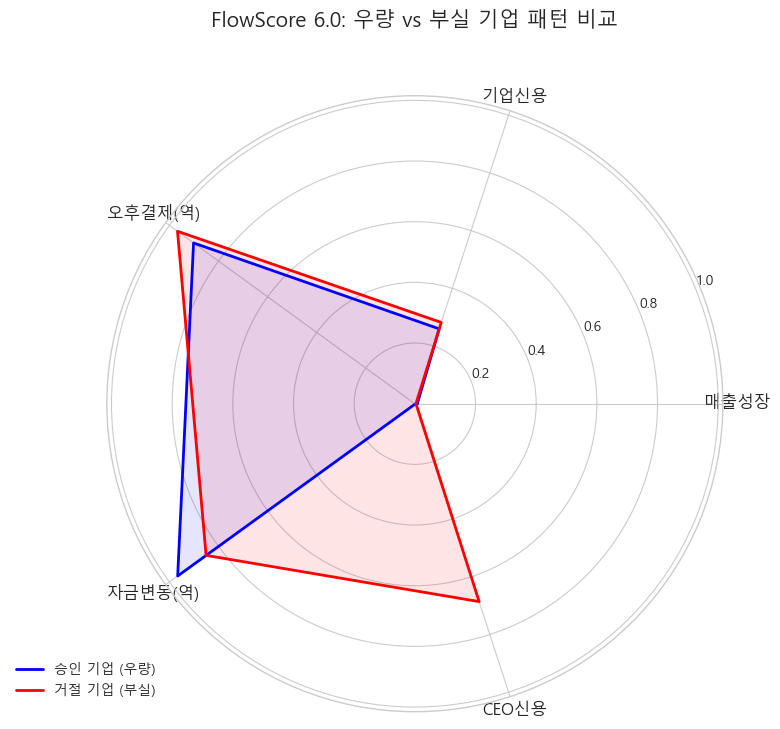

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from math import pi

# 시각화 설정 (한글 폰트 지원)
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.family'] = 'Malgun Gothic' # 윈도우용
plt.rcParams['axes.unicode_minus'] = False

print("🚀 [FlowScore 6.0 Final] 심사역을 위한 모델 설명서 생성 중...")

# ==============================================================================
# 1. 모델 및 데이터 로드 (버전 업데이트)
# ==============================================================================
MODEL_FILE = 'FlowScore_6.0_Final_Hybrid.pkl'  # 6.0 최종 하이브리드 모델
DATA_FILE = 'Flow_Training_Final_CTGAN.csv'    # 데이터 패턴 분석용 (CTGAN 기반)

if not os.path.exists(MODEL_FILE):
    # 만약 하이브리드 파일명이 다르면 직전 단계 파일명으로 시도
    MODEL_FILE = 'FlowScore_6.0_Final.pkl' 
    if not os.path.exists(MODEL_FILE):
        print(f"❌ 모델 파일이 없습니다: {MODEL_FILE}")
        exit()

print(f"✅ 모델 로드 완료: {MODEL_FILE}")
model = joblib.load(MODEL_FILE)
df = pd.read_csv(DATA_FILE) if os.path.exists(DATA_FILE) else None

# ==============================================================================
# 2. 피처 정의서 (Feature Dictionary)
# ==============================================================================
# 심사역이 이해하기 쉬운 용어로 매핑
feature_meta = {
    # [심사역 우선순위]
    'Sales_Growth':     {'name': '매출성장률',     'cat': '핵심지표(심사역)', 'desc': '전년 대비 성장 속도 (높을수록 좋음)'},
    'Biz_Score':        {'name': '기업신용점수',   'cat': '핵심지표(심사역)', 'desc': '외부 평가기관 등급 점수'},
    'Avg_Delay_Days':   {'name': '평균지연일수',   'cat': '핵심지표(심사역)', 'desc': '지급 예정일 대비 지연일'},
    'Late_Pay_Ratio':   {'name': '오후결제비율',   'cat': '핵심지표(심사역)', 'desc': '마감 시간 임박 결제 비중'},

    # [AI 발굴 지표]
    'Tx_Volatility':    {'name': '자금변동성',     'cat': '보조지표(AI)',     'desc': '월별 자금 소요의 불규칙성 (낮을수록 좋음)'},
    'Avg_Tx_Hour':      {'name': '평균결제시간',   'cat': '보조지표(AI)',     'desc': '주로 결제하는 시간대 (오전일수록 좋음)'},
    'Weekend_Tx_Ratio': {'name': '주말거래비율',   'cat': '보조지표(AI)',     'desc': '비영업일 거래 비중 (0에 가까워야 함)'},
    
    # [기초 체력]
    'Current_Ratio':    {'name': '유동비율',       'cat': '기초체력',         'desc': '단기 상환 능력'},
    'Debt_Ratio':       {'name': '부채비율',       'cat': '기초체력',         'desc': '자본 대비 부채 비중'},
    'OPM_Change':       {'name': '이익률변화',     'cat': '기초체력',         'desc': '수익성 개선 여부'},
    'Rev_Per_Emp':      {'name': '인당생산성',     'cat': '기초체력',         'desc': '직원 1인당 매출액'},
    
    # [신뢰도]
    'CEO_Score':        {'name': 'CEO신용점수',    'cat': '신뢰도',           'desc': '대표자 개인 신용도'},
    'Emp_Momentum':     {'name': '인력변동추세',   'cat': '신뢰도',           'desc': '최근 인력 이탈/충원 추세'}
}

# ==============================================================================
# 3. 핵심 판단 기준 시각화 (Feature Importance)
# ==============================================================================
features = list(feature_meta.keys())
# 모델에 있는 피처만 추출 (안전장치)
valid_features = [f for f in features if f in model.feature_names_in_]
importances = model.feature_importances_

# 데이터프레임 변환
df_imp = pd.DataFrame({
    'Feature': model.feature_names_in_,
    'Importance': importances
})
# 메타정보 매핑
df_imp['Korean_Name'] = df_imp['Feature'].map(lambda x: feature_meta.get(x, {}).get('name', x))
df_imp['Category'] = df_imp['Feature'].map(lambda x: feature_meta.get(x, {}).get('cat', '기타'))
df_imp = df_imp.sort_values('Importance', ascending=False)

# 그래프 그리기
plt.figure(figsize=(14, 8))
# 색상 지정: 심사역 픽(빨강), AI 픽(파랑), 기초(회색)
colors = {'핵심지표(심사역)': '#d62728', '보조지표(AI)': '#1f77b4', '기초체력': '#7f7f7f', '신뢰도': '#2ca02c'}
bar_colors = df_imp['Category'].map(colors)

bars = plt.barh(df_imp['Korean_Name'], df_imp['Importance'], color=bar_colors)
plt.xlabel('AI 중요도 기여율 (Contribution)')
plt.title('FlowScore 6.0 Final 심사 기준 (심사역 기준 + AI 지능 결합)')
plt.gca().invert_yaxis() 

# 범례 추가
handles = [plt.Rectangle((0,0),1,1, color=c) for c in colors.values()]
plt.legend(handles, colors.keys(), title="지표 카테고리")

# 값 표시
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.005, bar.get_y() + bar.get_height()/2, f'{width*100:.1f}%', va='center')

plt.tight_layout()
plt.savefig('FlowScore_6.0_Importance.png')
print("✅ [1] 중요도 그래프 저장됨: FlowScore_6.0_Importance.png")

# ==============================================================================
# 4. 우량 vs 부실 기업 프로파일 비교 (Radar Chart)
# ==============================================================================
print("📊 [2] 우량 vs 부실 기업 패턴 비교 차트 생성 중...")

# 6.0 모델의 핵심 5대 지표 (심사역 픽 + AI 픽 혼합)
radar_cols = ['Sales_Growth', 'Biz_Score', 'Late_Pay_Ratio', 'Tx_Volatility', 'CEO_Score']
radar_names = ['매출성장', '기업신용', '오후결제(역)', '자금변동(역)', 'CEO신용']

def normalize(series):
    return (series - series.min()) / (series.max() - series.min())

if df is not None:
    df_norm = df.copy()
    for col in radar_cols:
        df_norm[col] = normalize(df_norm[col])

    # 역방향 지표 뒤집기 (낮을수록 좋은 것 -> 높을수록 좋게 변환)
    for col in ['Late_Pay_Ratio', 'Tx_Volatility']:
        df_norm[col] = 1 - df_norm[col]

    # 승인 vs 거절 평균
    avg_good = df_norm[df_norm['Grade']=='Approve'][radar_cols].mean().values
    avg_bad = df_norm[df_norm['Grade']=='Reject'][radar_cols].mean().values
    
    # 레이더 차트 설정
    N = len(radar_cols)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    avg_good = np.concatenate((avg_good, [avg_good[0]]))
    avg_bad = np.concatenate((avg_bad, [avg_bad[0]]))

    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    
    plt.xticks(angles[:-1], radar_names, size=12)
    
    # 우량 (파란색)
    ax.plot(angles, avg_good, linewidth=2, linestyle='solid', label='승인 기업 (우량)', color='blue')
    ax.fill(angles, avg_good, 'blue', alpha=0.1)
    
    # 부실 (빨간색)
    ax.plot(angles, avg_bad, linewidth=2, linestyle='solid', label='거절 기업 (부실)', color='red')
    ax.fill(angles, avg_bad, 'red', alpha=0.1)
    
    plt.title('FlowScore 6.0: 우량 vs 부실 기업 패턴 비교', size=15, y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    
    plt.savefig('FlowScore_6.0_Radar_Chart.png')
    print("✅ [2] 레이더 차트 저장됨: FlowScore_6.0_Radar_Chart.png")

# ==============================================================================
# 5. 피처 설명서 엑셀 저장
# ==============================================================================
# 중요도 순위 재계산
rank_map = {name: i+1 for i, name in enumerate(df_imp['Feature'])}

df_desc = pd.DataFrame(feature_meta).T
df_desc = df_desc[['name', 'cat', 'desc']]
df_desc['중요도 순위'] = df_desc.index.map(lambda x: rank_map.get(x, 99))
df_desc = df_desc.sort_values('중요도 순위')
df_desc.columns = ['한글명', '카테고리', '설명', 'AI중요도순위']

print("\n📋 [FlowScore 6.0 심사 가이드라인]")
print(df_desc.to_string())
df_desc.to_csv('FlowScore_6.0_Guide.csv', encoding='utf-8-sig')
print("\n💾 가이드라인 저장 완료: FlowScore_6.0_Guide.csv")